In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df1=pd.read_csv("bengaluru_house_prices.csv")
print(df1.head())

print(df1.columns)

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [3]:
df2=df1.drop(['area_type','availability','balcony','society'],axis='columns')
df2.head()
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [4]:
df3=df2.copy()
df3=df3.dropna()
print(df3.isnull().sum())
df3['bhk']=df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3['bhk'].unique()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [5]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [6]:
def con_to_num(x):
    tokens=x.split('-')
    if len(tokens)==2:
      return ((float(tokens[0]))+(float(tokens[1])))/2
    try:
        return float(x)
    except:
        return None
df4=df3.copy()
df4.total_sqft=df4['total_sqft'].apply(con_to_num)
df4=df4[df4['total_sqft'].notnull()]
df4.head(5)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [7]:
df5=df4.copy()
df5['price_per_sqft']=df5['price']*100000/df5['total_sqft']

df5.location=df5.location.apply(lambda x: x.strip())
location_cnts=df5.location.value_counts(ascending=False)
location_cnts

location
Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [8]:
print(len(location_cnts[location_cnts<10]))
locations_lessthan10=location_cnts[location_cnts<=10]
print(locations_lessthan10)

print(len(df5.location.unique()))

df5.location=df5.location.apply(lambda x: 'other' if x in locations_lessthan10 else x )

print(len(df5.location.unique()))


1033
location
BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: count, Length: 1047, dtype: int64
1287
241


In [9]:
df6=df5[df5.total_sqft/df5.bhk>=300]

def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key , subdf in df.groupby('location'):
        m=np.mean(subdf['price_per_sqft'])
        st=np.std(subdf['price_per_sqft'])
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df7=remove_pps_outliers(df6)
df7.shape

(10242, 7)

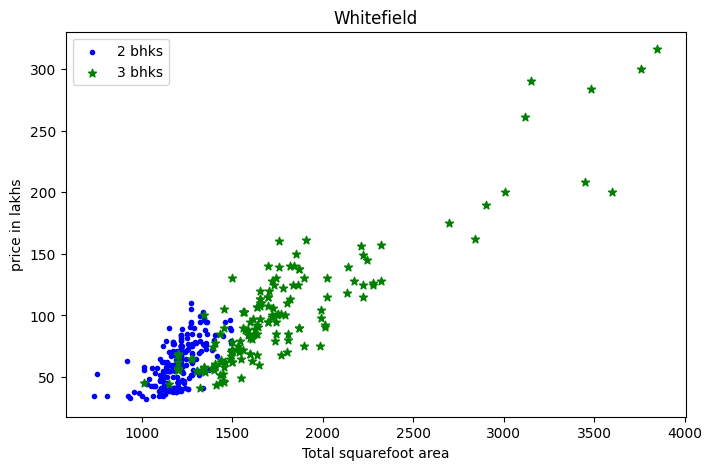

In [10]:
def plot_scatter_chart(df,location):
    bhk2=df[(df.location==location)&(df.bhk==2)]
    bhk3=df[(df.location==location)&(df.bhk==3)]
    plt.rcParams['figure.figsize']=(8,5)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',marker='.',label='2 bhks')
    plt.scatter(bhk3.total_sqft,bhk3.price,color='green',marker='*',label='3 bhks')
    plt.xlabel('Total squarefoot area')
    plt.ylabel('price in lakhs')
    plt.title(location)
    plt.legend()

    plt.show()

plot_scatter_chart(df7,"Whitefield")

(7317, 7)


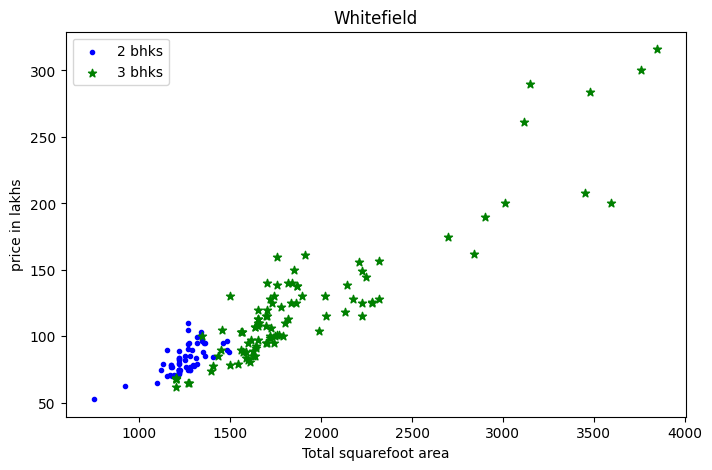

In [11]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
print(df8.shape)

plot_scatter_chart(df8,"Whitefield")

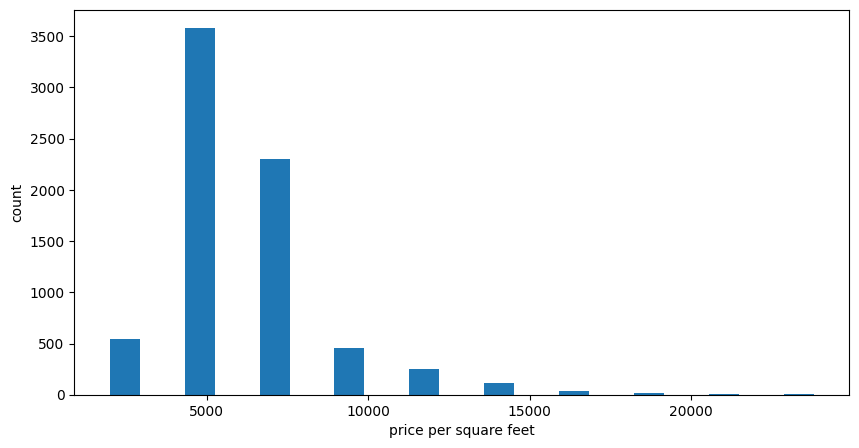

In [12]:
plt.rcParams['figure.figsize']=(10,5)
plt.hist(df8.price_per_sqft,rwidth=0.4)
plt.xlabel("price per square feet")
plt.ylabel("count")
plt.show()

In [13]:
print(df8.bath.unique())
df9=df8[df8.bath<df8.bhk+2]
df9.shape

[ 4.  3.  2.  5.  8.  1.  6.  7.  9. 12. 16. 13.]


(7239, 7)

In [14]:
df10=df9.drop(['size','price_per_sqft'],axis='columns')
dummies=pd.get_dummies(df10.location)
df11=pd.concat([df10,dummies.drop(['other'],axis='columns')],axis='columns')
df12=df11.drop(['location'],axis='columns')
df12=df12.dropna()

In [15]:
x=df12.drop(['price'],axis='columns')
y=df12.price

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=10)

In [16]:
from sklearn.linear_model import LinearRegression
lr_clf=LinearRegression()
lr_clf.fit(x_train,y_train)
lr_clf.score(x_test,y_test)

0.8629132245229444

In [17]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(),x,y,cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

In [18]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': { }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    pd.pandas.set_option("display.max_columns",None)
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(x,y)

,model,best_score,best_params
0,linear_regression,0.847796,{}
1,lasso,0.726823,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.685971,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [19]:
x.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=243)

In [20]:
np.where(x.columns=='Vishwapriya Layout')[0][0]

235

In [21]:
def predict_price(location,sqft,bath,bhk):
    
    loc_index=np.where(x.columns==location)[0][0]
    fet=np.zeros(len(x.columns))
    fet[0]=sqft
    fet[1]=bath
    fet[2]=bhk
    
    if (loc_index>=0):
        fet[loc_index]=1
    return lr_clf.predict([fet])[0]

In [22]:
predict_price('Whitefield',1200,3,2)

c:\Users\mahes\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


73.46689941983234

In [23]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
        pickle.dump(lr_clf,f)

In [24]:
import json
columns ={
    "data_columns":[col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    json.dump(columns,f)
   